In [1]:
import sys
sys.path.append('..')
import torch
from torchvision import datasets, transforms
from models import VAE, loss_function
from problems import get_problem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

p = get_problem('sum_25', 'int', train_ratio=1.)

def get_digit(digit, train):
    test_digits = []
    for data, label in datasets.MNIST('../data', train=train, download=True, transform=transforms.ToTensor()):
        if digit == -1 or label.item() == digit:
            test_digits.append((data, label))
    return test_digits

In [94]:
# Load all VAES
vaes = {}
for i in xrange(10):
    vae = VAE()
    state_dict = torch.load('digit_{}_epoch_80.pth'.format(i))
    vae.load_state_dict(state_dict)
    vaes[i] = vae

In [95]:
# Load all MNISTs
batch_size = 1

# Load all MNIST digits
test_digits = {}
test_loaders = {}
for i in xrange(10):
    print 'Loading digit', i
    test_digit = get_digit(i, train=False)
    test_digits[i] = test_digit
    
    test_loader = torch.utils.data.DataLoader(test_digit, batch_size=batch_size, shuffle=True)
    test_loaders[i] = test_loader

Loading digit 0
Loading digit 1
Loading digit 2
Loading digit 3
Loading digit 4
Loading digit 5
Loading digit 6
Loading digit 7
Loading digit 8
Loading digit 9


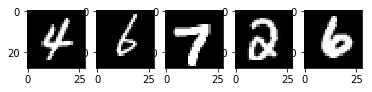

In [194]:
# Combination to Visual
def to_visual(combination):
    x = []
    for c in combination:
        x.append(iter(test_loaders[c]).next()[0][0])
    visual_combination = torch.cat(x)
    return visual_combination

visual_combination = to_visual(p.train_positive[7])

for i in xrange(5):
    plt.subplot(1,5,i+1)
    plt.imshow(visual_combination[i].numpy(), cmap='gray')

# Likelihood of Sum-25 with Joint generator

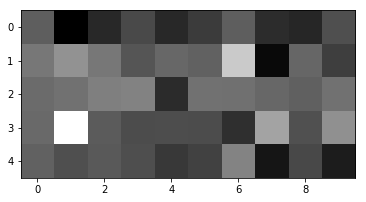

In [203]:
# Precompute conditional visual likelihoods
def get_visual_likelihood(visual_combination):  # return -log likelihoods
    visual_likelihoods = np.zeros((5, 10))
    for part in xrange(5):
        for model_idx in xrange(10):
            x = visual_combination[part].view((1, 1, 28, 28))
            reconstruction, mu, logvar = vaes[model_idx](x)
            l = loss_function(reconstruction, x, mu, logvar).item()
            visual_likelihoods[part, model_idx] = l  # since it's -log likelihood
    return visual_likelihoods

visual_combination = to_visual(p.train_positive[6])  # this function is random
visual_likelihoods = get_visual_likelihood(visual_combination)
plt.imshow(visual_likelihoods, 'gray')


In [208]:
# Sum over all combinations in symbolic model
conditional_likelihoods = []

def log_sum_exp(v):
    v = np.asarray(v)
    v_max = v.max()
    return v_max + np.log(np.sum(np.exp(v - v_max)))


def get_likelihood(p, visual_likelihoods):
    conditional_likelihoods = []
    for combination in p.train_positive:  # iterate over possible z
        tmp = 0.
        for part, c in enumerate(combination):
            p_xPart_given_zPart = visual_likelihoods[part, c]
            tmp += p_xPart_given_zPart
        conditional_likelihoods.append(tmp)
    likelihood = np.log(len(p.train_positive)) - log_sum_exp(-np.asarray(conditional_likelihoods))  # get NLL
    # for debugging return closest combination
    best_x_z = np.argmin(conditional_likelihoods)  # smallest log likelihood
    closest_combination = p.train_positive[best_x_z]
    return likelihood, conditional_likelihoods, closest_combination
    
    
likelihood, conditional_likelihoods, closest_combination = get_likelihood(p, visual_likelihoods)

# Note that the largest conditional likelihood should correspond classifying the combination
print 'Closest combination match', closest_combination

print 'Likelihood', likelihood

Closest combination match [6 6 4 0 9]
Likelihood 420.7110621616804


# Repeat this over all training set combinations X model combinations

In [214]:
all_likelihoods = []
for i, combination in enumerate(p.train_positive):
    visual_combination = to_visual(combination)  # this function is random
    visual_likelihoods = get_visual_likelihood(visual_combination)  
    likelihood, conditional_likelihoods, closest_combination = get_likelihood(p, visual_likelihoods)
    
    all_likelihoods.append(likelihood)
    if i % 50 == 0:
        print 'Combination #', i
        print 'Combination', combination
        print 'closest', closest_combination
        print 'Likelihood', likelihood
        average_nll = np.mean(all_likelihoods)
        std = np.std(all_likelihoods) / np.sqrt(len(all_likelihoods))
        print 'Average NLL: {:.1f} +/- {:.1f}'.format(average_nll, std) 

Combination # 0
Combination [6 6 4 0 9]
closest [6 6 4 0 9]
Likelihood 421.003939358946
Average NLL: 421.0 +/- 0.0
Combination # 50
Combination [7 4 5 3 6]
closest [7 4 5 3 6]
Likelihood 495.78402206158273
Average NLL: 500.6 +/- 7.1
Combination # 100
Combination [4 5 4 5 7]
closest [4 5 4 5 7]
Likelihood 476.41385909771554
Average NLL: 491.9 +/- 4.7
Combination # 150
Combination [3 1 9 7 5]
closest [3 1 9 7 5]
Likelihood 468.6549403355085
Average NLL: 492.7 +/- 4.3
Combination # 200
Combination [6 4 7 1 7]
closest [6 4 7 1 7]
Likelihood 408.7533976719343
Average NLL: 487.7 +/- 3.7
Combination # 250
Combination [6 3 8 2 6]
closest [6 3 8 2 6]
Likelihood 499.5480296299421
Average NLL: 489.3 +/- 3.4
Combination # 300
Combination [3 5 8 1 8]
closest [3 5 8 1 8]
Likelihood 469.25355788921945
Average NLL: 490.0 +/- 3.2
Combination # 350
Combination [2 8 5 7 3]
closest [2 8 5 7 3]
Likelihood 537.370997159239
Average NLL: 490.1 +/- 2.9
Combination # 400
Combination [5 2 3 9 6]
closest [5 2 3 9

KeyboardInterrupt: 

In [207]:
p.train_positive.shape

(5631, 5)